In [2]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
import flax
from typing import Any
import numpy as np
import functools
from einops import rearrange
import tqdm
import time

# Attention

> **Attention** is an operator which communicates information between a *set* of feature tokens.

In many cases, an object is best represented as a *set* of features. For example, a sentence is a set of words, and an image is a set of visual patches. The **attention** operator gives us a way to condition over these features, which we will refer to as **tokens**. A typical intermediate layer for an attention-based neural network has the shape `[batch, num_tokens, num_features]`, as opposed to the typical `[batch, num_features]`.

By structuring our computation in terms of tokens, we can use the same **parameter-sharing** philosophy from convolutional and recurrent layers. **Attention shares parameters across a set of tokens in parallel**.



<!-- The **attention** operator is a way for neural networks to condition over a set of feature vectors. We will refer to these vectors as **tokens**. In attention layers, you should view information about an input as  -->

<!-- The **attention** operator is a way for neural networks to condition over a set of parallel feature vectors. As a classic example, imagine you have a sentence of 100 words, and you represent each word as a feature vector of length 512. Viewed as one, that's 51,200 features, which is too much. Thankfully, we can use the same **parameter-sharing** philosophy from convolutional and recurrent layers, and re-use the same parameters for each word. **Attention shares parameters across a set of feature vectors in parallel**. -->

The attention operator produces a new token for every input token, and *each output token is a function of all other tokens*. A naive thing we could do is learn a single dense layer, apply it to every token, then sum up those results. But we run into an issue -- some of the other tokens are relevant, but most are not. We would like a way to **selectively condition** on only the relevant tokens.

Instead, we will accomplish this selective conditioning by using a learned function to decide how much 'attention' to pay to each token. We use a dense layer to generate **key** vectors for each token. We then learn a **query** vector for each token as well. The attention weighting can now be calculated as a dot product between the keys and queries. Each token is now summed via the attention-weighting to get the final output vector.

## Example: Attention over Colored Arrows

Let's construct some simple attention matrices to illustrate the principle. Our input tokens will be 2D arrows, each with an assossiated color. The key vectors will simply be the 5-dimensional vector containing direction and color.

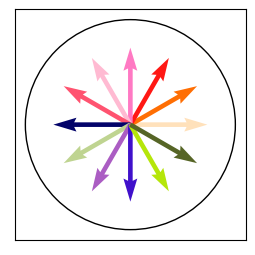

In [38]:
input_colors = np.random.uniform(size=(12, 3))
input_colors[:6, 0] = 1
input_angles = np.arange(0, 2*np.pi, 2*np.pi/12)[:, None]
input_vectors = np.concatenate([np.cos(input_angles), np.sin(input_angles), input_colors], axis=1)

def plot_data(input_vectors):
    L = input_vectors.shape[0]
    arrow_directions = input_vectors[:, :2]
    arrow_colors = input_vectors[:, 2:]
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.quiver(np.zeros(L), np.zeros(L), arrow_directions[:, 0], arrow_directions[:, 1], color=arrow_colors, scale=3, width=0.02)
    circle = plt.Circle((0, 0), 1, fill=False, color='black')
    ax.add_artist(circle)
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    plt.show()
plot_data(input_vectors)

Note how we have biased the upper colors to contain more red. To reveal this bias, we can run attention over these arrows. Let's view the result when using an upwards vs. downwards vector as our query.

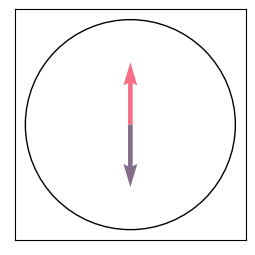

In [39]:
query_up = np.array([0, 3, 0, 0, 0])
query_down = np.array([0, -3, 0, 0, 0])

def attention(inputs, query):
    similarity = inputs @ (query[:, None])
    attention = jax.nn.softmax(similarity, axis=0)
    return jnp.sum(attention * inputs, axis=0)

c1 = attention(input_vectors, query_up)
c2 = attention(input_vectors, query_down)

# plot colors.
plot_data(np.stack([c1, c2]))

The attention operator returns a red arrow when queried with an upwards arrow, and a purple-grayish arrow when queried with a downwards arrow. This example shows how attention can query certain features (e.g. arrow direction) to retrieve correlated features within the set of tokens (color).

## Attention in Neural Networks

Attention in neural networks follows the same principles. Typically, given a set of input tokens, we will introduce dense layers to calculate three quantities:
```
keys = W_k @ inputs
queries = W_q @ inputs
values = W_v @ inputs
```
where the final output will calculate similarity between the `keys` and `queries`, then perform a weighted average over each `value`. Note how a seperate query is calculated for *each input token*, in this way an attention layer can process a set of tokens entirely in parallel, with each token producing a query attending to all other tokens.

In [9]:
class AttentionLayer(nn.Module):
    features: int = 512

    @nn.compact
    def __call__(self, x):
        print('Input shape:', x.shape)
        k, q, v = [nn.Dense(self.features)(x) for _ in range(3)]
        q = q / jnp.sqrt(q.shape[2]) # 1/sqrt(d) scaling.
        w = jnp.einsum('bqc,bkc->bqk', q, k)
        w = nn.softmax(w, axis=-1)
        print('Attention weights shape:', w.shape)
        print('Attention values shape:', v.shape)
        y = jnp.einsum('bqk,bkc->bqc', w, v)
        x = nn.Dense(self.features)(y)
        print('Output shape:', x.shape)
        return x
net = AttentionLayer()
params = net.init(jax.random.PRNGKey(0), jnp.zeros((1, 100, 512)))['params']

Input shape: (1, 100, 512)
Attention weights shape: (1, 100, 100)
Attention values shape: (1, 100, 512)
Output shape: (1, 100, 512)


## Where does the softmax come from?

In traditional attention, the key/query dot products are passed through a softmax function to compute weightings. The softmax helps to *normalize* the outputs, so the total weightings always sum to one. The exponential nature of the softmax also helps networks learn to attend completely to a certain token. In principle, it is possible to use alternative normalization functions instead of the softmax. See [cosFormer](https://arxiv.org/pdf/2202.08791).

## Where does the `sqrt(q.shape[2])` come from?

The dot product of two `N`-length unit Gaussian vectors has a standard deviation which scales with `sqrt(N)`. To account for this behavior, we normalize the dot product outputs by this constant value during the attention pass. By doing so, the expected magnitude of the dot product remains constant regardless of how large our feature dimension is.

## Multi-Headed Attention

In the above implementation, each input token generates a *single* query vector, which is used to query the rest of the tokens. To increase expressivity, we can do this multiple times. **Multi-head attention** refers to a structure where each input token generates `K` **heads** of keys, queries, and values. Attention is calculated indpendently among each head, and the final outputs are concatenated together at the end. Multi-head attention is typically implemented with a single dense layer for all heads, and the heads are split up prior to calculating attention weights.

In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    features: int = 512
    num_heads: int = 8

    @nn.compact
    def __call__(self, x):
        print('Input shape:', x.shape)
        channels_per_head = self.features // self.num_heads
        k, q, v = [nn.Dense(self.features)(x) for _ in range(3)]
        k, q, v = [jnp.reshape(p, (x.shape[0], x.shape[1], self.num_heads, channels_per_head)) for p in [k, q, v]]
        q = q / jnp.sqrt(q.shape[3]) # 1/sqrt(d) scaling.
        w = jnp.einsum('bqhc,bkhc->bhqk', q, k) # [B, HW, HW, num_heads]
        w = w.astype(jnp.float32)
        w = nn.softmax(w, axis=-1)
        print('Attention weights shape:', w.shape)
        print('Attention values shape:', v.shape)
        y = jnp.einsum('bhqk,bkhc->bqhc', w, v)
        y = jnp.reshape(y, x.shape)
        x = nn.Dense(self.features)(y)
        print('Output shape:', x.shape)
        return x
net = MultiHeadAttentionLayer()
params = net.init(jax.random.PRNGKey(0), jnp.zeros((1, 100, 512)))['params']

Input shape: (1, 100, 512)
Attention weights shape: (1, 8, 100, 100)
Attention values shape: (1, 100, 8, 64)
Output shape: (1, 100, 512)


## Self-Attention vs Cross-Attention

The examples implemented above accomplish **self-attention**, where each token can attend to every other token, including itself. Self-attention is helpful as a plug-and-play replacement for dense layers, and can be seen as performing general computation (over a set).

Another form is **cross-attention**, which calculates keys and values over a *different* set of a tokens. This is useful when we want to attend to auxilliary or conditioning information. For example, in a text-conditioned diffusion model, we may want to learn a transformation over the image-related tokens that can attend to the text-related tokens. To do this, we could use cross-attention. The image-related tokens are used to generate query vectors, which attend to the key/value pairs generated from the text tokens.

In [7]:
class CrossAttention(nn.Module):
    features: int = 512

    @nn.compact
    def __call__(self, x, z):
        print('Input shape (x):', x.shape)
        print('Input shape (z):', z.shape)
        k = nn.Dense(self.features)(z)
        q = nn.Dense(self.features)(x)
        v = nn.Dense(self.features)(z)
        q = q / jnp.sqrt(q.shape[2]) # 1/sqrt(d) scaling.
        w = jnp.einsum('bqc,bkc->bqk', q, k) # [B, HW, HW, num_heads]
        w = nn.softmax(w, axis=-1)
        print('Attention weights shape:', w.shape)
        print('Attention values shape:', v.shape)
        y = jnp.einsum('bqk,bkc->bqc', w, v) # [B, HW, num_heads, channels_per_head]
        x = nn.Dense(self.features)(y)
        print('Output shape:', x.shape)
        return x
net = CrossAttention()
params = net.init(jax.random.PRNGKey(0), jnp.zeros((1, 100, 512)), jnp.zeros((1, 32, 128)))['params']

Input shape (x): (1, 100, 512)
Input shape (z): (1, 32, 128)
Attention weights shape: (1, 100, 32)
Attention values shape: (1, 32, 512)
Output shape: (1, 100, 512)


## Positional Embedding

Attention is **permutation-invariant**. If the order of the input tokens is swapped around, there will be no change in the outputs (other than the corresponding swaps). This property is in contrast to previous parameter-sharing methods (convolution and recurrence) which use either spatial or temporal relationships to form connections. Attention simply uses a weighted sum over *all* other feature vectors.

To address this, we typically use **positional embedding**. At the start of an attention layer, we introduce additoinal information that represents the *position* of each token in the total set of tokens. For a language model, we would encode the sequential position of each word. For a patch-based image model, we would encode the spatial X/Y position of each patch. Typical position encoding schemes would represent each scalar position as a vector of sine/cosine frequencies. The positional information is added directly to the feature vectors of each token.

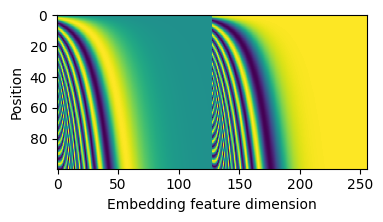

In [24]:
def positional_embedding(pos, embed_dim=256):
    omega = jnp.arange(embed_dim // 2, dtype=jnp.float32) / (embed_dim // 2)
    omega = 1. / 10000**omega
    pos = pos.reshape(-1)
    out = jnp.einsum('m,d->md', pos, omega)
    emb = jnp.concatenate([jnp.sin(out), jnp.cos(out)], axis=1)
    return emb
enc = positional_embedding(jnp.arange(0, 100))

fig, ax = plt.subplots(figsize=(4, 2))
ax.imshow(enc, aspect='auto')
ax.set_xlabel('Embedding feature dimension')
ax.set_ylabel('Position')
plt.show()

## Rotary Position Embedding (RoPE)

In contrast to the absolute positions encoded above, attention typically benefits from having access to **relative positional encoding**, where each query-key product is a function of *relative* position between each vector. The standard way to do this is via the **Rotary Position Embedding (RoPE)**.

To understand RoPE, let us first review two properties of dot products.
- $q^Tk = |q||k|cos(\theta)$. Dot products are a function of the magnitude and *angle* between two vectors.
- $q^Tk = \sum_n q_n ^T k_n$. Dot products can be decomposed into a sum of smaller dot products between subsets of each vector.

Now we will consider a simple case where $q$ and $k$ are 2-dimensional. We can encode the relative positional information by *rotating* each q/k vector according to its position. Since dot products are a function of the angle between vectors, the dot products between rotated vectors are now a function of their original directions and the *relative* difference. We can formulate this with a matrix multiplication:

$$
RoPE(x, pos) = \begin{bmatrix}
cos(pos) & -sin(pos) \\
sin(pos) & cos(pos) \\
\end{bmatrix} x
$$

and note that the dot product between two RoPE-encoded vectors is now a function of relative position.

$$
\begin{align}
    RoPE(x, pos1)^T RoPE(y, pos2) & = \begin{bmatrix}
    x_1 cos(pos1) - x_2 sin(pos1) \\
    x_2 cos(pos1) - x_1 sin(pos1) \\
    \end{bmatrix} \begin{bmatrix}
    y_1 cos(pos2) - y_2 sin(pos2) \\
    y_2 cos(pos2) - y_1 sin(pos2) \\
    \end{bmatrix}^T \\
    & = (x_1 cos(pos1) - x_2 sin(pos1))(y_1 cos(pos2) - y_2 sin(pos2)) + \\
    & \qquad (x_2 cos(pos1) - x_1 sin(pos1))(y_2 cos(pos2) - y_1 sin(pos2)) \\
    & = x_1 y_1 cos(pos1 - pos2) + x_1 y_2 sin(pos1 - pos2) - \\
    & \qquad x_2 y_1 sin(pos2 - pos1) + x_2 y_2 cos(pos2 - pos1) \\
    & = f(x, y, pos1 - pos2)
\end{align}
$$

**RoPE in N-dimensional space.** To generalize this technique to multiple dimensions, we will view every 2 dimensions as an independent 2D vector. Each of these directions is rotated with a different multplicative constant $\theta_d$ (i.e. amount of rotation per positional distance). Because of the decomposition property of dot-products, this operation can be done while maintaing all the desirable properties of dot products.

$$
f(q, k, pos1, pos2) = (R_{pos1} W_q)^T(R_{pos2} W_k)\\
$$

$$
R_{p} = 
	\begin{pmatrix}
		\cos{p\theta_1}& -\sin{p\theta_1}&0&0&\cdots&0&0\\
		\sin{p\theta_1}&\cos{p\theta_1}&0&0&\cdots&0&0 \\
		0&0&\cos{p\theta_2}& -\sin{p\theta_2}&\cdots&0&0\\
		0&0&\sin{p\theta_2}&\cos{p\theta_2}&\cdots&0&0 \\
		\vdots&\vdots&\vdots&\vdots&\ddots&\vdots&\vdots\\
		0&0&0&0&\cdots&\cos{p\theta_{d/2}}& -\sin{p\theta_{d/2}}\\
		0&0&0&0&\cdots&\sin{p\theta_{d/2}}&\cos{p\theta_{d/2}}
	\end{pmatrix}
$$

In [17]:
def apply_rope(q, k, pos, theta=10000):
    dim = q.shape[-1]
    scale = jnp.arange(0, dim, 2) / dim
    omega = 1.0 / (theta**scale)
    freqs = jnp.einsum("...n,d->...nd", pos, omega)
    freqs = jnp.stack([jnp.cos(freqs), -jnp.sin(freqs), jnp.sin(freqs), jnp.cos(freqs)], axis=-1)
    freqs = rearrange(freqs, "b n d (i j) -> b n d i j", i=2, j=2)
    qr = jnp.reshape(q, (*q.shape[:-1], -1, 1, 2))
    kr = jnp.reshape(k, (*k.shape[:-1], -1, 1, 2))
    q_out = freqs[..., 0] * qr[..., 0] + freqs[..., 1] * qr[..., 1]
    k_out = freqs[..., 0] * kr[..., 0] + freqs[..., 1] * kr[..., 1]
    return jnp.reshape(q_out, q.shape), jnp.reshape(k_out, k.shape)

class AttentionLayerRoPE(nn.Module):
    features: int = 512

    @nn.compact
    def __call__(self, x):
        pos = jnp.arange(x.shape[1])[None, :]
        k, q, v = [nn.Dense(self.features)(x) for _ in range(3)]
        q, k = apply_rope(q, k, pos)
        q = q / jnp.sqrt(q.shape[2]) # 1/sqrt(d) scaling.
        w = jnp.einsum('bqc,bkc->bqk', q, k)
        w = nn.softmax(w, axis=-1)
        print('Attention weights shape:', w.shape)
        print('Attention values shape:', v.shape)
        y = jnp.einsum('bqk,bkc->bqc', w, v)
        x = nn.Dense(self.features)(y)
        print('Output shape:', x.shape)
        return x
net = AttentionLayerRoPE()
params = net.init(jax.random.PRNGKey(0), jnp.zeros((1, 100, 512)))['params']

Attention weights shape: (1, 100, 100)
Attention values shape: (1, 100, 512)
Output shape: (1, 100, 512)


## Causal Attention

In tasks such as language modelling, we may want to constrain the context that each token can attend do. **Causal attention** is a formulation where each token can only attend to tokens that occur *previously* in the positionally-ordered set. We can implement causal attention with a simple mask over the dot products. For a given query-key matrix, we should set all values above the diagonal to zero.

In [ ]:
class CausalAttention(nn.Module):
    features: int = 512

    @nn.compact
    def __call__(self, x):
        k, q, v = [nn.Dense(self.features)(x) for _ in range(3)]
        q = q / jnp.sqrt(q.shape[2]) # 1/sqrt(d) scaling.
        w = jnp.einsum('bqc,bkc->bqk', q, k)
        mask = jnp.tril(jnp.ones((x.shape[1], x.shape[1])), 0)
        print('Attention mask looks like:')
        print(mask)
        w = w - 1e9 * mask[None, :, :] # Remove masked weights from softmax.
        w = nn.softmax(w, axis=-1)
        w = jnp.where(mask[None, :, :], 0, w) # Zero out masked weights.
        y = jnp.einsum('bqk,bkc->bqc', w, v)
        x = nn.Dense(self.features)(y)
        return x
net = CausalAttention()
params = net.init(jax.random.PRNGKey(0), jnp.zeros((1, 10, 512)))['params']

Attention mask looks like:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


## References

https://github.com/black-forest-labs/flux/blob/main/src/flux/math.py#L6

https://arxiv.org/abs/2104.09864

https://arxiv.org/abs/1706.03762

https://arxiv.org/abs/1409.0473

